# Approximating a Lorentz system

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional

import random
from random import seed, random
from sklearn.utils import shuffle

%matplotlib inline

/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


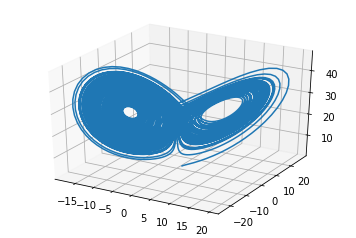

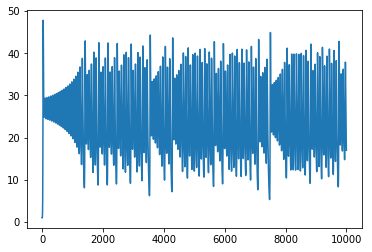

In [12]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
  x, y, z = state  # unpack the state vector
  return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 100.0, 0.01)

states = odeint(f, state0, t)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(states[:,0], states[:,1], states[:,2])
plt.show()

pdata = pd.DataFrame({"a_noisy":states[:,2]})
data = pdata
plt.plot(data)

In [13]:
# np.random.seed(1337)  # for reproducibility

# # Simulate data
# cycle = 100
# step = 0.1
# noise = 0.00 # standard deviation from 0
# decaying_coef = 0.01

# end_pt = 2 * np.pi * cycle
# t = np.arange(0, end_pt, step)
# a = np.sin(t) * np.sin(0.5 * t) * np.sin(0.2 * t) * np.sin(0.3 * t) * np.sin(2 * t)
# a_noisy = a + np.random.normal(0, noise, a.size)
# a_decaying = a_noisy * np.exp(-decaying_coef * t)
# pdata = pd.DataFrame({"a_noisy":a_decaying})
# data = pdata

# Note: If noise is not modulated by the exponential function, it will overwhelm the signal near the end of the data sequence
# which is where test data is picked from. We can modulate it in simulated environment but in experiments, we may have to discard
# data near the end of the motion.

In [14]:
# visualize data
# n_plot = int(a.size / 10)

# _, axarr = plt.subplots(3, sharex=True, sharey=True)
# axarr[0].plot(a[:n_plot])
# axarr[0].set_title('Population')
# axarr[1].plot(a_decaying[:n_plot])
# axarr[1].set_title('Observation')
# axarr[2].plot(a[:n_plot], label="Population")
# axarr[2].plot(a_decaying[:n_plot], label="Observation")
# axarr[2].set_title('Population and Observation')
# axarr[2].legend()
# plt.tight_layout()
# plt.show()

In [15]:
def _load_data(data, n_prev = 100):
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.2):  
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(df) * (1 - test_size)))

    X_train, y_train = _load_data(df.iloc[0:ntrn])
    X_test, y_test = _load_data(df.iloc[ntrn:])

    return (X_train, y_train), (X_test, y_test)

# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(data, 0.3)

In [16]:
# define model structure
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=False), input_shape=(None, 1)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False)))
model.add(Dense(units=10, activation="linear"))
model.add(Dense(units=1, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

In [17]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.1)

Train on 6210 samples, validate on 690 samples
Epoch 1/10
6210/6210 [==============================] - 9s 1ms/step - loss: 215.3457 - val_loss: 38.6052
Epoch 2/10
6210/6210 [==============================] - 8s 1ms/step - loss: 9.8363 - val_loss: 1.2300
Epoch 3/10
6210/6210 [==============================] - 8s 1ms/step - loss: 0.6024 - val_loss: 0.1928
Epoch 4/10
6210/6210 [==============================] - 8s 1ms/step - loss: 0.1952 - val_loss: 0.0691
Epoch 5/10
6210/6210 [==============================] - 8s 1ms/step - loss: 0.0949 - val_loss: 0.0301
Epoch 6/10
6210/6210 [==============================] - 8s 1ms/step - loss: 0.0596 - val_loss: 0.0245
Epoch 7/10
6210/6210 [==============================] - 8s 1ms/step - loss: 0.0414 - val_loss: 0.0622
Epoch 8/10
6210/6210 [==============================] - 8s 1ms/step - loss: 0.0288 - val_loss: 0.0250
Epoch 9/10
6210/6210 [==============================] - 8s 1ms/step - loss: 0.0208 - val_loss: 0.1076
Epoch 10/10
6210/6210 [=========

In [18]:
# evaluate model fit
score = model.evaluate(X_test, y_test)
print('Test score:', score)

2900/2900 [==============================] - 1s 392us/step
Test score: 0.03249334086439219


In [19]:
# visualize predictions
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

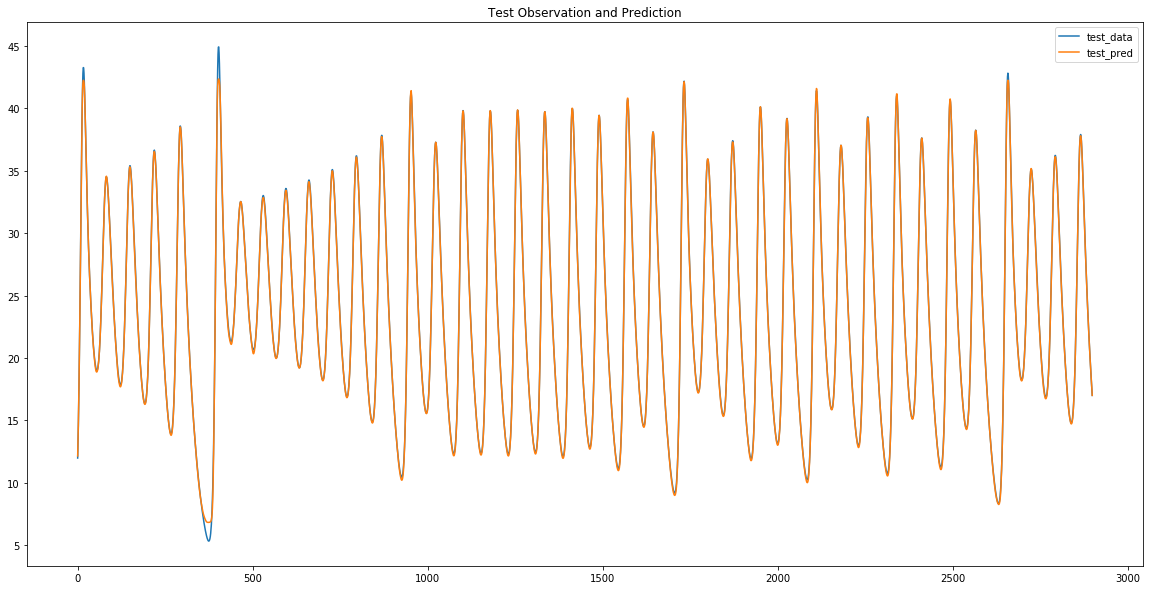

In [20]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:], label='test_data')
plt.plot(test_prediction[:], label='test_pred')
plt.title('Test Observation and Prediction')
plt.legend()

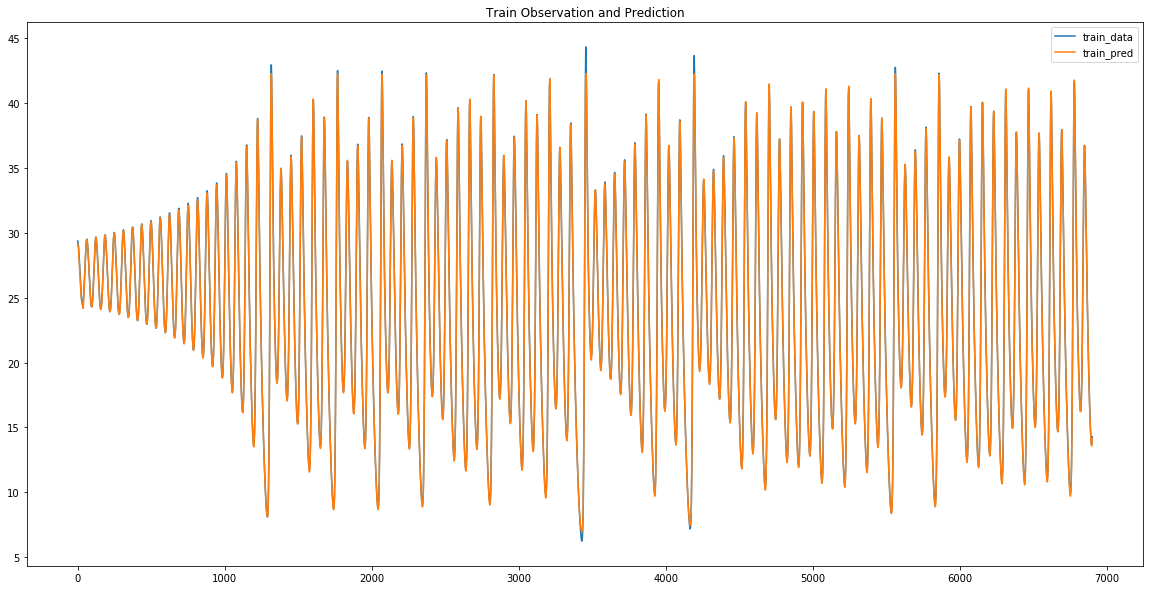

In [21]:
plt.figure(figsize=(20,10))
plt.plot(y_train[0:], label='train_data')
plt.plot(train_prediction[0:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()